In [1]:
import numpy as np

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is installed
import pickle

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score

# Check if seaborn style is available and apply it
try:
    plt.style.use('seaborn')
except OSError:
    print("Seaborn style not found, using default style")
    plt.style.use('default')

# Now you can proceed with your code


Seaborn style not found, using default style


In [3]:


# Load the CSV files (use forward slashes or double backslashes)
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
quali = pd.read_csv('qualifying.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
circuit = pd.read_csv('circuits.csv')


In [4]:
# Example: Renaming the 'url' column in one of the DataFrames
drivers.rename(columns={'url': 'drivers_url'}, inplace=True)
constructors.rename(columns={'url': 'constructors_url'}, inplace=True)

# Now perform the merges
try:
    df1 = pd.merge(races, results, how='inner', on=['raceId'])
    df2 = pd.merge(df1, quali, how='inner', on=['raceId', 'driverId', 'constructorId'])
    df3 = pd.merge(df2, drivers, how='inner', on=['driverId'])
    df4 = pd.merge(df3, constructors, how='inner', on=['constructorId'])
    df5 = pd.merge(df4, circuit, how='inner', on=['circuitId'])

    print(df5.head())
    
except ValueError as ve:
    print(f"Error during merging: {ve}")
except KeyError as ke:
    print(f"KeyError during merging: {ke}")

   raceId  year  round  circuitId                 name_x        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       1  2009      1          1  Australian Grand Prix  2009-03-29   
2      18  2008      1          1  Australian Grand Prix  2008-03-16   
3      36  2007      1          1  Australian Grand Prix  2007-03-18   
4      55  2006      3          1  Australian Grand Prix  2006-04-02   

     time_x                                              url_x  resultId  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...      7554   
1  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...      7555   
2  04:30:00  http://en.wikipedia.org/wiki/2008_Australian_G...        18   
3  03:00:00  http://en.wikipedia.org/wiki/2007_Australian_G...       383   
4  14:00:00  http://en.wikipedia.org/wiki/2006_Australian_G...       796   

   driverId  ...  nationality_y                              constructors_url  \
0        18  ...        Briti

In [5]:
data = df5.drop(['round', 'circuitId', 'time_x', 'url_x', 'resultId', 'driverId',
                  'constructorId', 'number_x', 'positionText', 'position_x',
                  'positionOrder', 'laps', 'time_y', 'rank',
                  'fastestLapTime', 'fastestLapSpeed', 'qualifyId', 'driverRef', 'number', 'code', 'url_y', 'circuitRef',
                  'location', 'lat', 'lng', 'alt', 'number_y', 'points', 'constructorRef', 'name_x', 'raceId', 'fastestLap', 'q2', 'q3', 'milliseconds', 'q1'], 
                  axis=1, errors='ignore')

print("Data after dropping columns:", data)

Data after dropping columns:       year        date  grid  statusId  position_y    forename      surname  \
0     2009  2009-03-29     1         1           1      Jenson       Button   
1     2009  2009-03-29     2         1           2      Rubens  Barrichello   
2     2008  2008-03-16    12         4          13      Jenson       Button   
3     2007  2007-03-18    14        11          14      Jenson       Button   
4     2006  2006-04-02     1        11           1      Jenson       Button   
...    ...         ...   ...       ...         ...         ...          ...   
8398  1994  1994-10-16    25         5          25       David      Brabham   
8399  1994  1994-10-16    21        12          21  Alessandro      Zanardi   
8400  1994  1994-10-16    22        13          22        Éric      Bernard   
8401  1994  1994-10-16    23        91          23        Érik        Comas   
8402  1994  1994-10-16    24         6          24      Hideki         Noda   

             dob natio

In [6]:
#considering data points from 2010
data = data[data['year']>=2010]

In [7]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [8]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [9]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [10]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [11]:
# Reasons for DNF (Did Not Finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3, 4, 20, 29, 31, 41, 68, 73, 81, 97, 82, 104, 107, 130, 137] else 0)

# Assuming you want to indicate DNF for constructors when statusId is in the list
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3, 4, 20, 29, 31, 41, 68, 73, 81, 97, 82, 104, 107, 130, 137, 1] else 0)

# Dropping unnecessary columns
data.drop(['forename', 'surname'], axis=1, inplace=True)


In [12]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

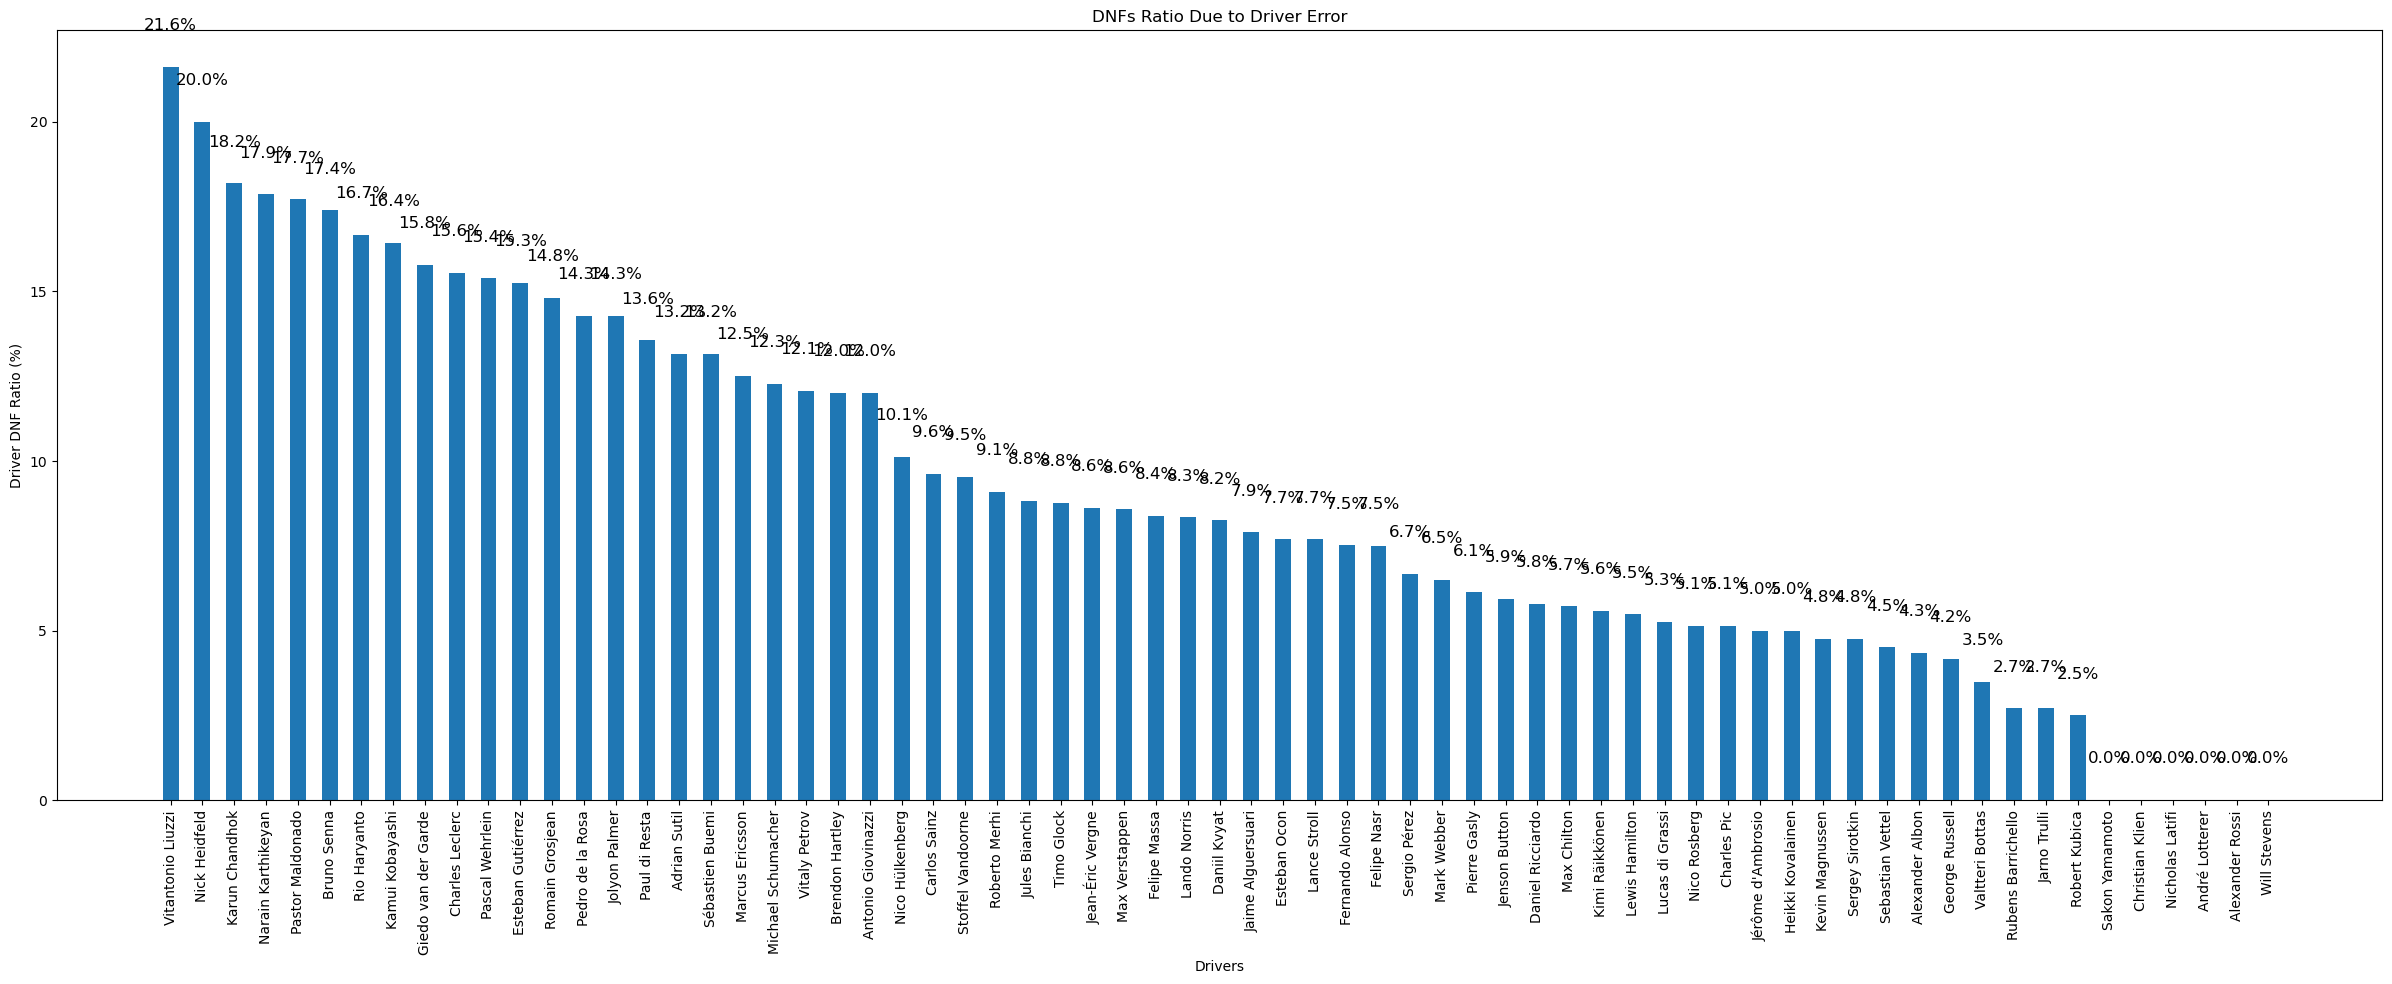

In [13]:
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()  # Sum of DNFs
driver_race_entered = data.groupby('driver')['driver_dnf'].count()  # Total races entered

# Calculating the DNF ratio
driver_dnf_ratio = (dnf_by_driver * 100 / driver_race_entered).sort_values(ascending=False)

# Setting up the plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=driver_dnf_ratio.index, height=driver_dnf_ratio, align='center', width=0.5)

# Rotating x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF Ratio (%)')
plt.title('DNFs Ratio Due to Driver Error')

# Adding data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 1)}%', 
             ha='center', va='bottom', fontdict={'size': 12})

# Display the plot
plt.show()

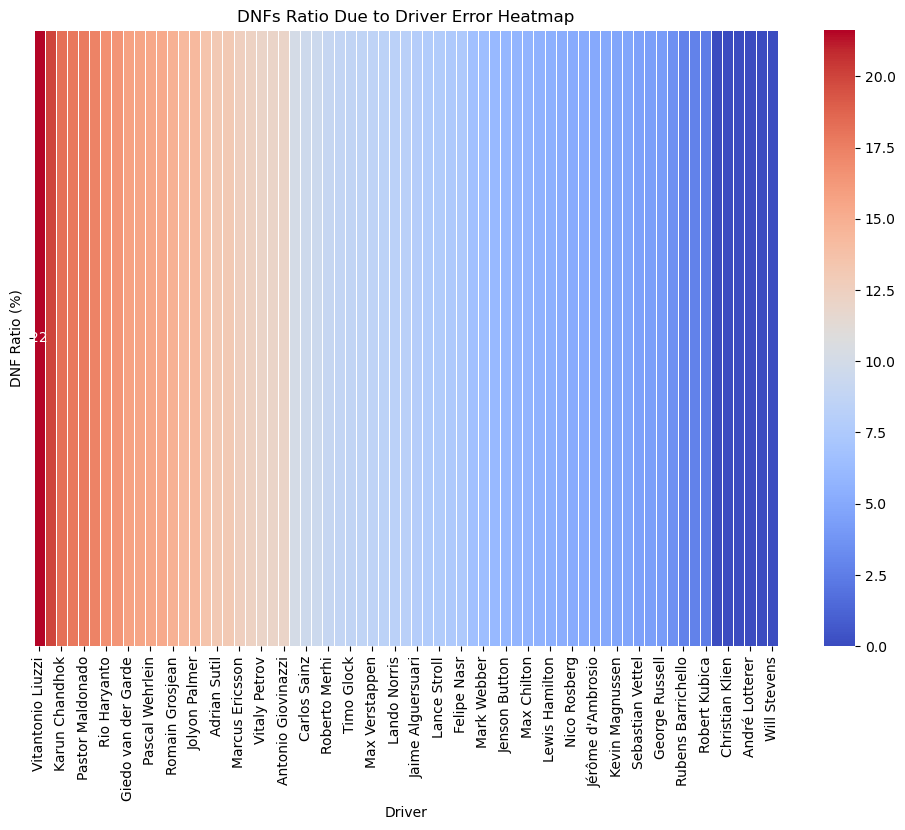

In [14]:

# Assuming 'data' is a pandas DataFrame
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()  # Sum of DNFs
driver_race_entered = data.groupby('driver')['driver_dnf'].count()  # Total races entered

# Calculating the DNF ratio
driver_dnf_ratio = (dnf_by_driver * 100 / driver_race_entered).sort_values(ascending=False)

# Convert to DataFrame for the heatmap
dnf_df = pd.DataFrame({'Driver': driver_dnf_ratio.index, 'DNF Ratio (%)': driver_dnf_ratio.values})

# Set up the heatmap plot
plt.figure(figsize=(12, 8))

# Use a pivot table to organize the data for the heatmap if needed (1D heatmap here)
# Create a 2D array with the data, adding dummy columns for plotting (use NaNs for missing values)
dnf_df_pivot = dnf_df.set_index('Driver').transpose()

# Plot the heatmap
sns.heatmap(dnf_df_pivot, annot=True, cmap='coolwarm', linewidths=0.5, cbar=True)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
plt.title('DNFs Ratio Due to Driver Error Heatmap')

# Display the heatmap
plt.show()


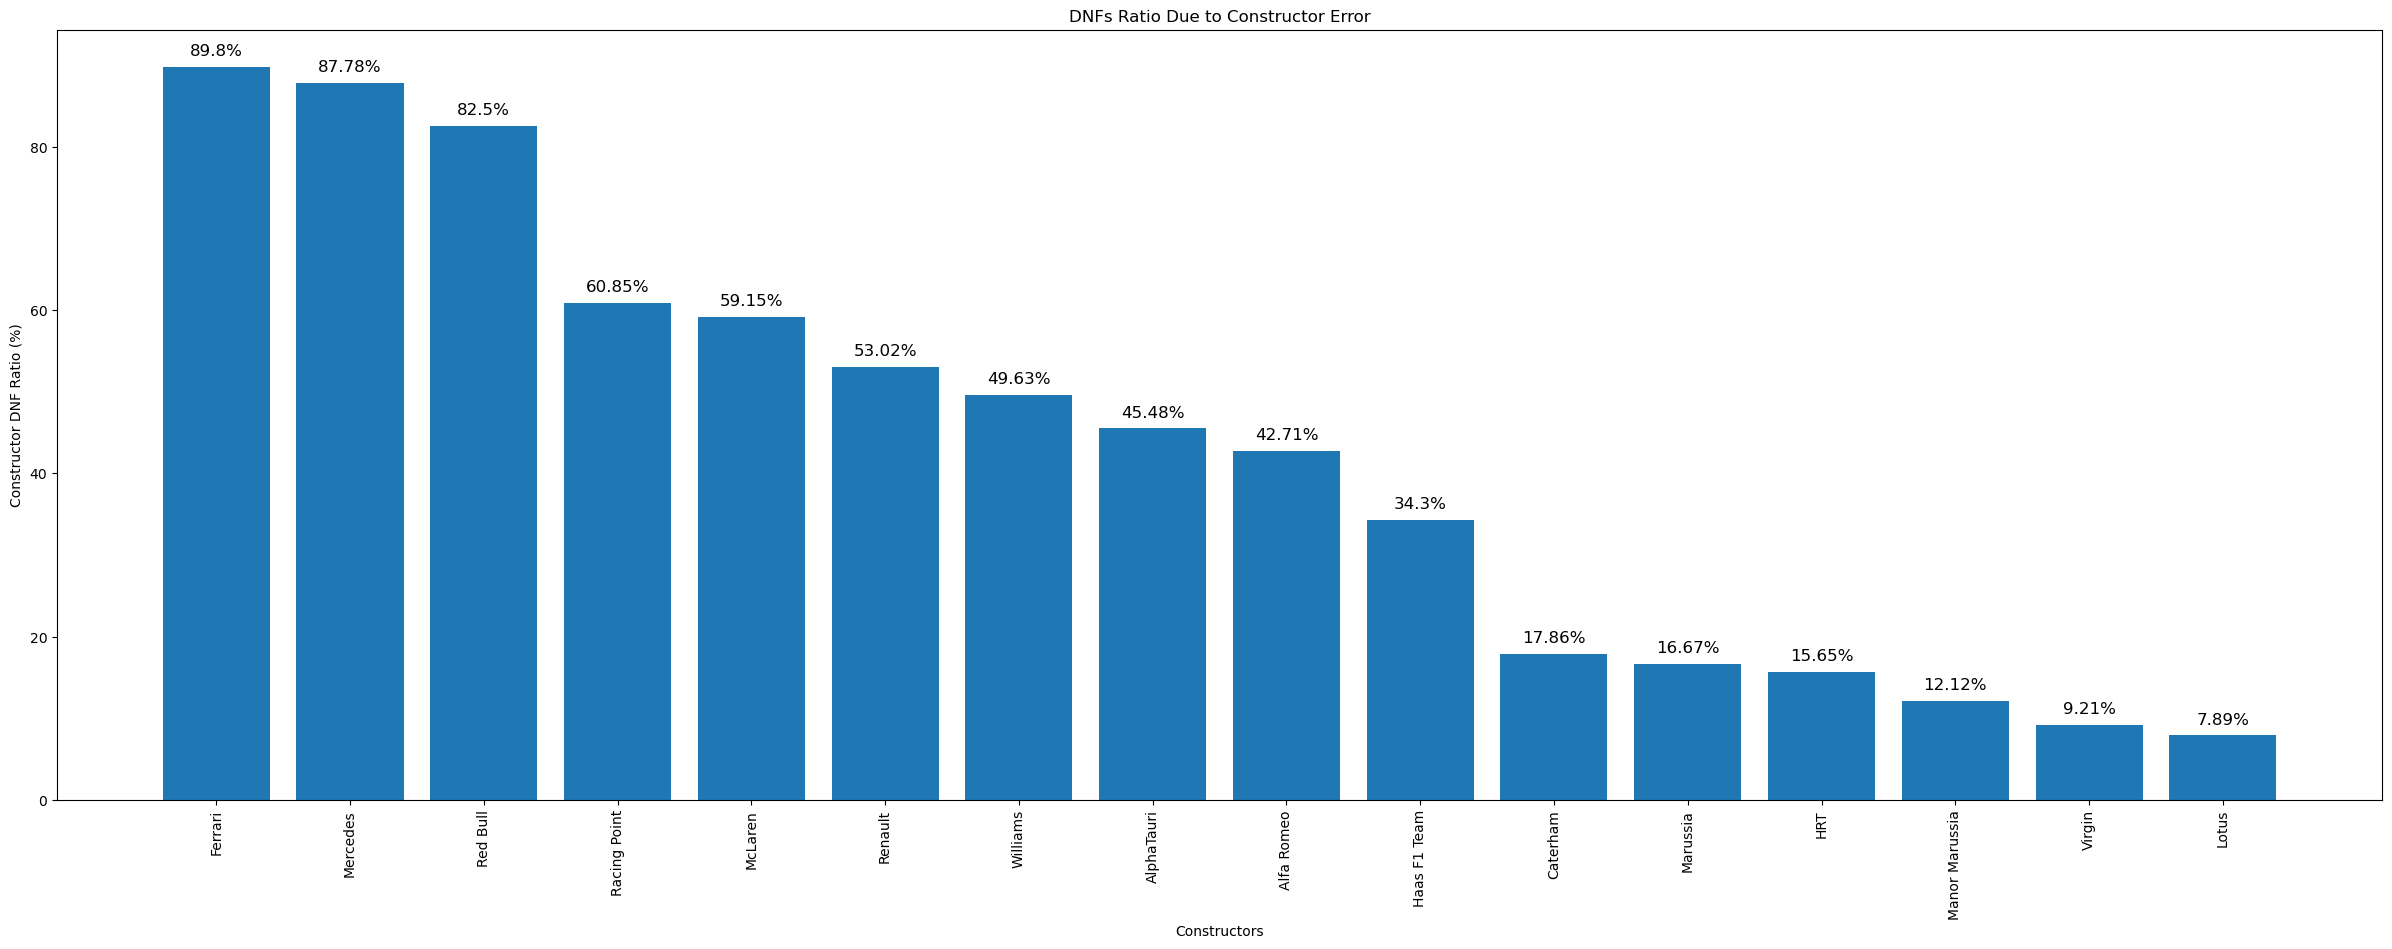

In [15]:
# Assuming 'data' is your DataFrame
# Grouping data by 'constructor' to calculate DNF stats
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()  # Sum of DNFs
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()  # Total races entered

# Calculating the DNF ratio
constructor_dnf_ratio = (dnf_by_constructor * 100 / constructor_race_entered).sort_values(ascending=False)

# Setting up the plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=constructor_dnf_ratio.index, height=constructor_dnf_ratio, align='center', width=0.8)

# Rotating x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF Ratio (%)')
plt.title('DNFs Ratio Due to Constructor Error')

# Adding data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 2)}%', 
             ha='center', va='bottom', fontdict={'size': 12})

# Display the plot
plt.show()

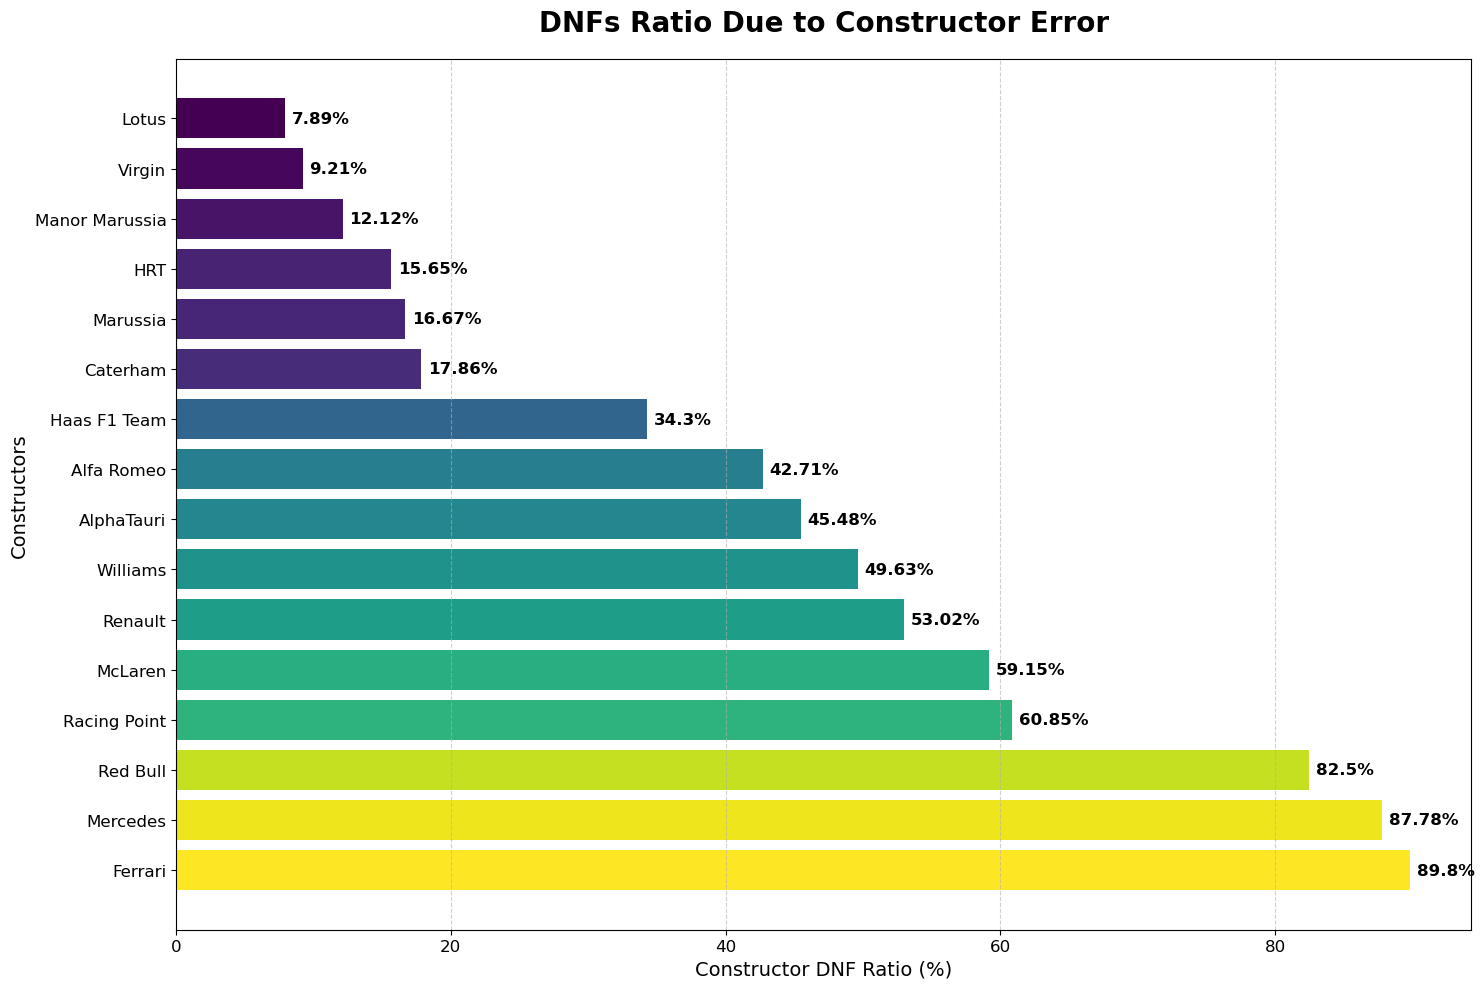

In [16]:
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()  # Sum of DNFs
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()  # Total races entered

# Calculating the DNF ratio
constructor_dnf_ratio = (dnf_by_constructor * 100 / constructor_race_entered).sort_values(ascending=False)

# Setting up the figure size
plt.figure(figsize=(15, 10))

# Create a color palette for the gradient bars
norm = plt.Normalize(constructor_dnf_ratio.min(), constructor_dnf_ratio.max())
colors = plt.cm.viridis(norm(constructor_dnf_ratio.values))

# Create a horizontal bar plot with vibrant colors
bars = plt.barh(y=constructor_dnf_ratio.index, width=constructor_dnf_ratio, color=colors)

# Add title and labels
plt.title('DNFs Ratio Due to Constructor Error', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Constructor DNF Ratio (%)', fontsize=14)
plt.ylabel('Constructors', fontsize=14)

# Annotating each bar with the DNF ratio value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{round(width, 2)}%', 
             va='center', ha='left', fontsize=12, fontweight='bold')

# Adding gridlines for clarity
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

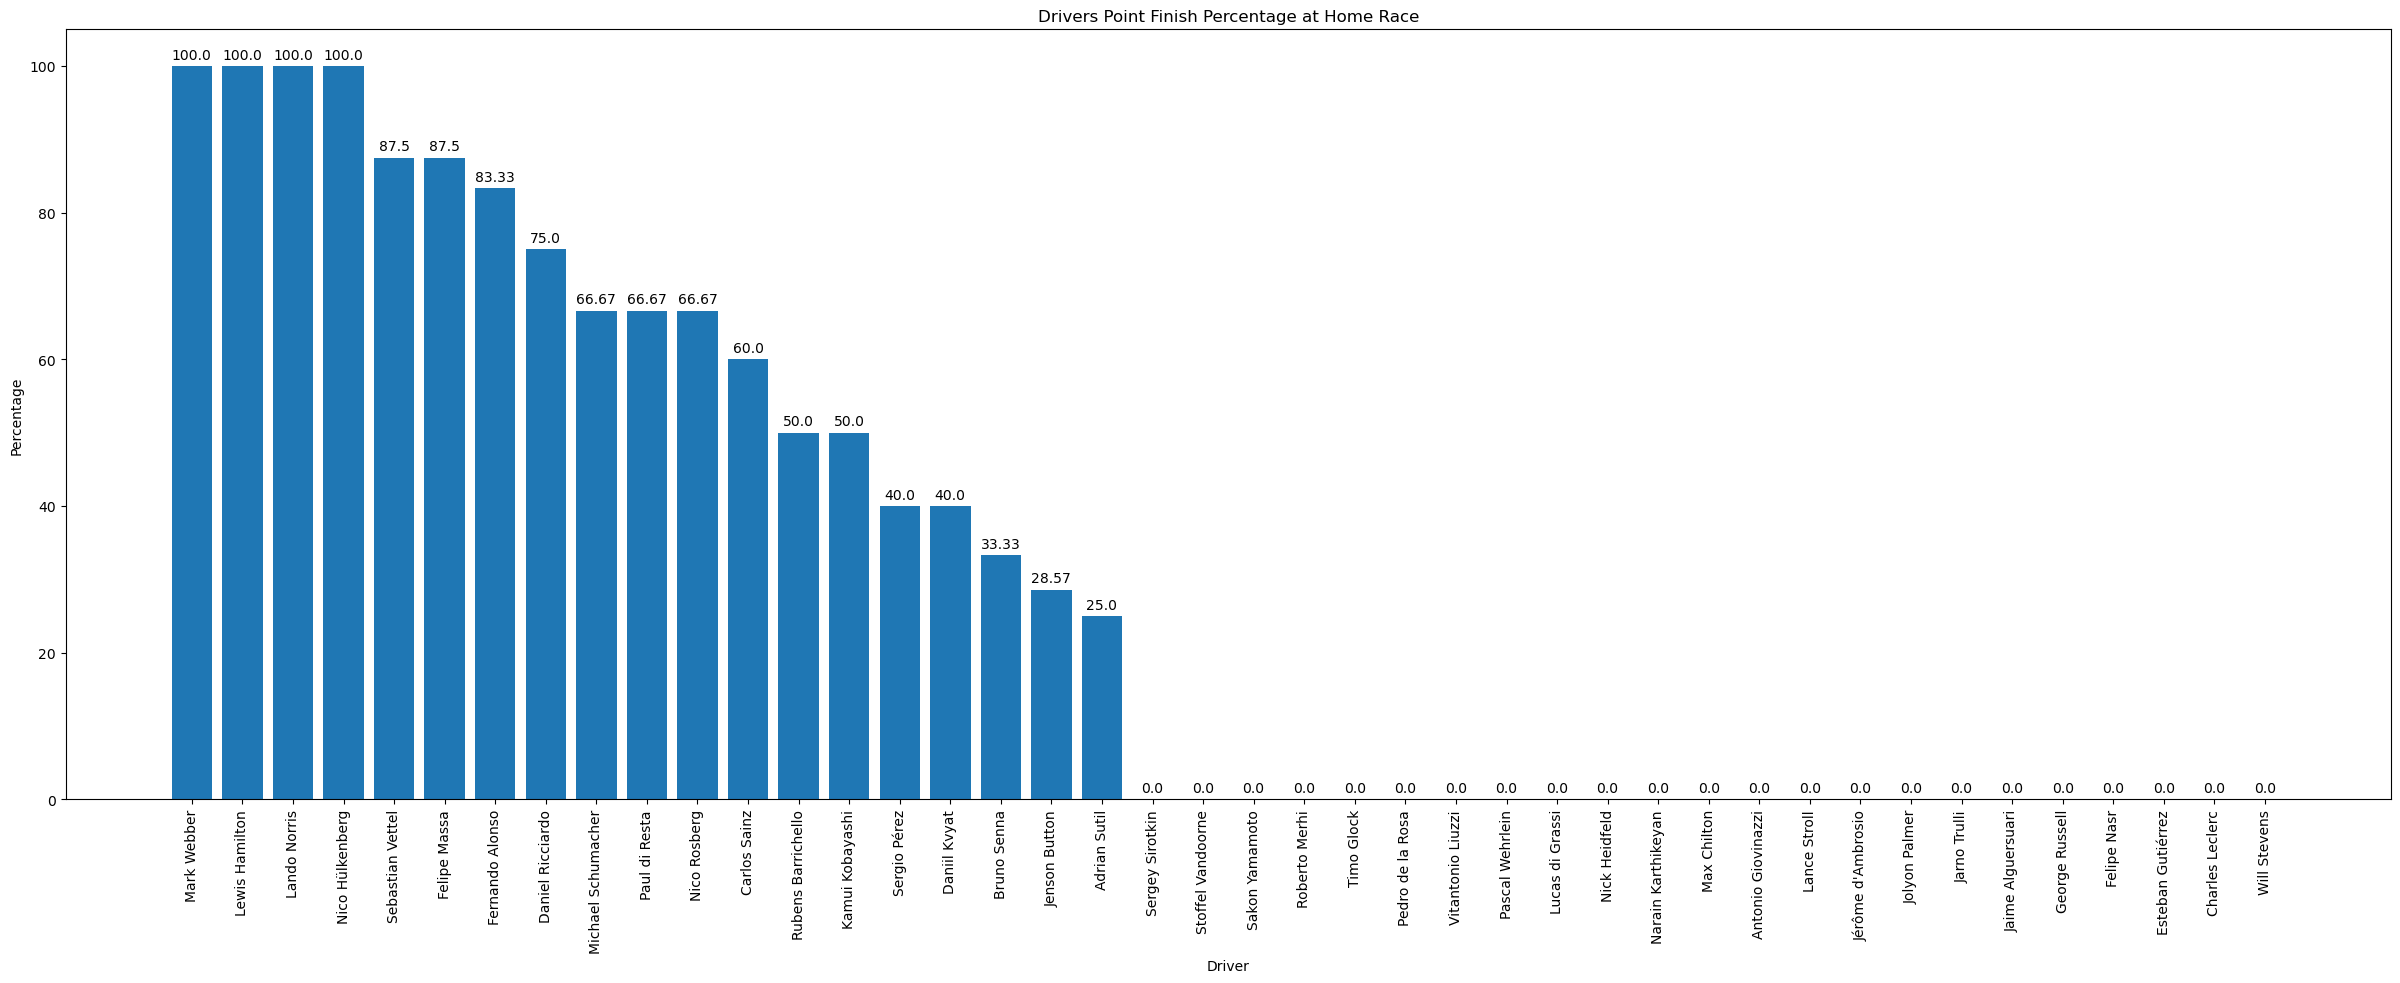

In [17]:

# Calculate points finished at home (counting finishes where position < 11)
driver_home_points_finish = data.loc[(data['position'] < 11) & (data['driver_home'] == 1)].groupby('driver').count()['position']

# Total home races: Count occurrences of home races instead of summing
total_home_races = data[data['driver_home'] == 1].groupby('driver').count()['driver_home']

# Calculate finish ratio (handle division by zero)
driver_home_point_finish_ratio = (driver_home_points_finish * 100 / total_home_races).fillna(0).sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=driver_home_point_finish_ratio.index, height=driver_home_point_finish_ratio, align='center', width=0.8)

# Customize x-axis and labels
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('Percentage')
plt.title('Drivers Point Finish Percentage at Home Race')

# Define font properties for the labels
font = {'size': 10}  # Adjust the size as needed

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 2)}', ha='center', fontdict=font)

# Show the plot
plt.show()




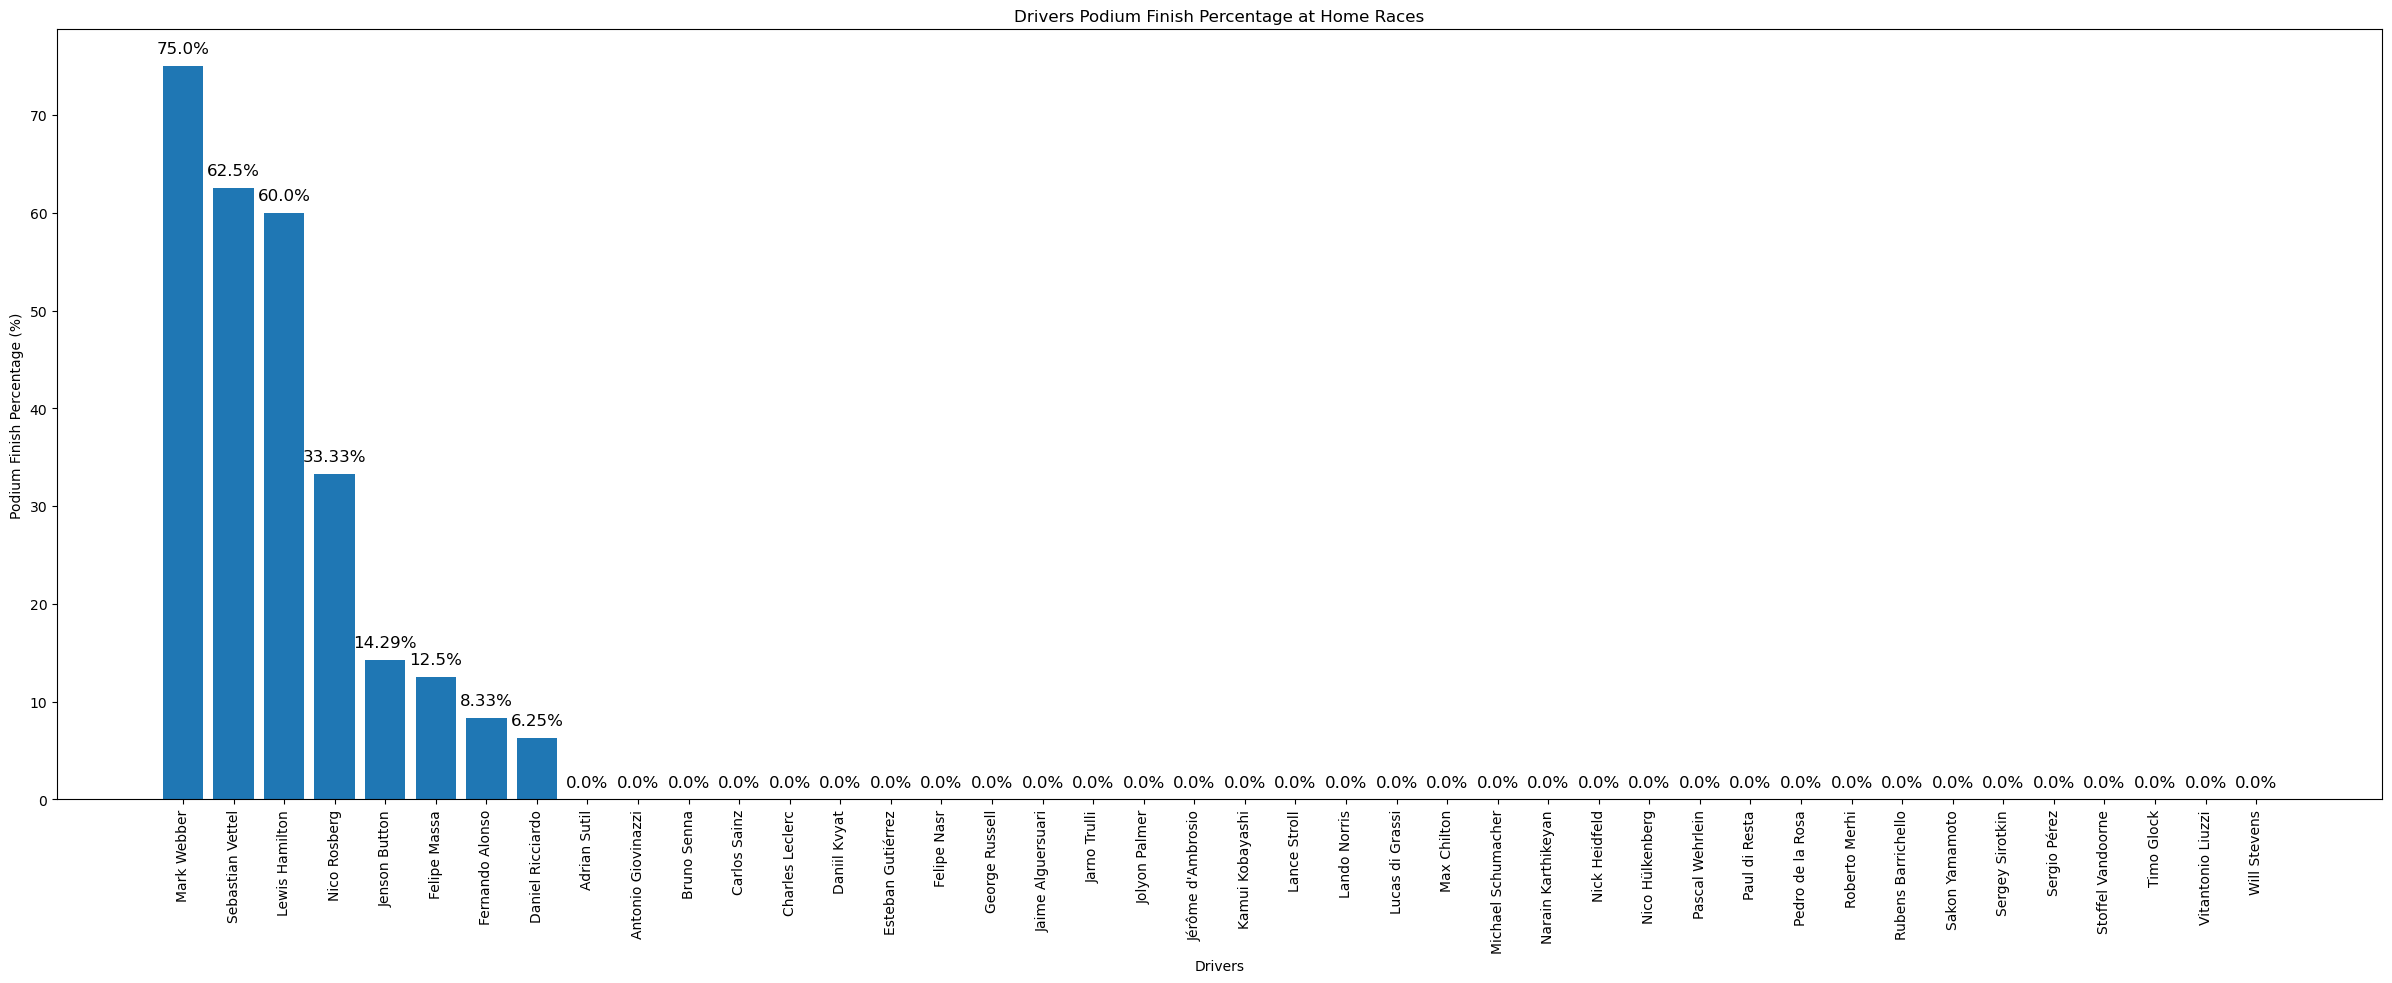

In [18]:


# Assuming 'data' is your DataFrame
# Count home podium finishes for each driver
driver_home_podium_finish = data.loc[(data['position'] < 4) & (data['driver_home'] == 1)].groupby('driver').count()['position']

# Count total home races for each driver
total_home_races = data[data['driver_home'] == 1].groupby('driver').count()['driver_home']

# Calculating the podium finish ratio
driver_home_podium_finish_ratio = (driver_home_podium_finish * 100 / total_home_races).sort_values(ascending=False).fillna(0)

# Setting up the plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index, height=driver_home_podium_finish_ratio, align='center', width=0.8)

# Rotating x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Podium Finish Percentage (%)')
plt.title('Drivers Podium Finish Percentage at Home Races')

# Adding data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 2)}%', 
             ha='center', va='bottom', fontdict={'size': 12})

# Display the plot
plt.show()


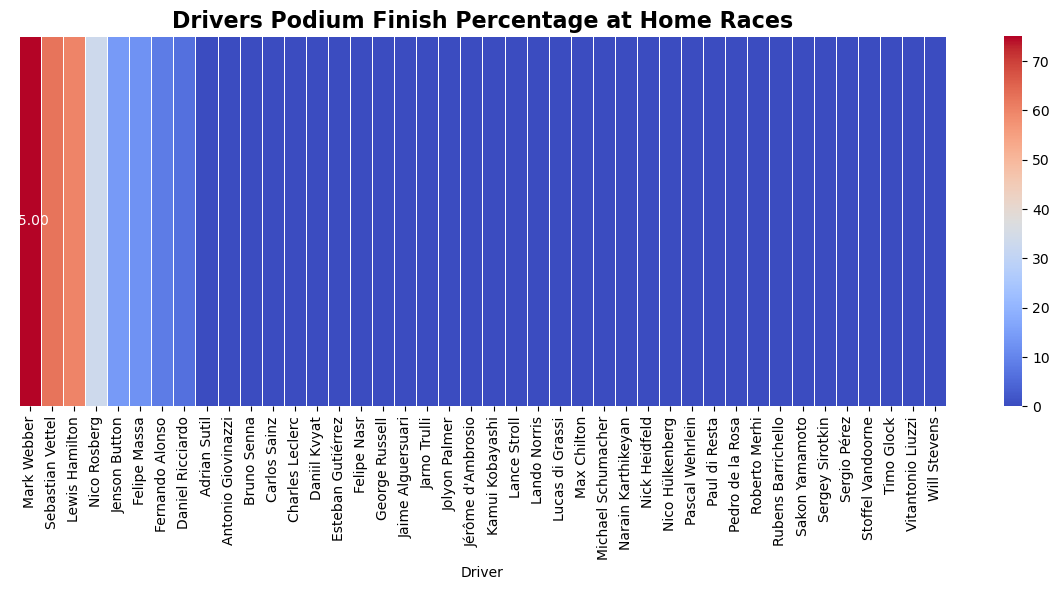

In [19]:
# Count home podium finishes for each driver
driver_home_podium_finish = data.loc[(data['position'] < 4) & (data['driver_home'] == 1)].groupby('driver').count()['position']

# Count total home races for each driver
total_home_races = data[data['driver_home'] == 1].groupby('driver').count()['driver_home']

# Calculating the podium finish ratio
driver_home_podium_finish_ratio = (driver_home_podium_finish * 100 / total_home_races).sort_values(ascending=False).fillna(0)

# Convert to DataFrame for the heatmap
df_podium_ratio = pd.DataFrame(driver_home_podium_finish_ratio).reset_index()
df_podium_ratio.columns = ['Driver', 'Podium Finish Ratio (%)']

# Set up the heatmap data for 1D heatmap
df_podium_pivot = df_podium_ratio.set_index('Driver').transpose()

# Plot the heatmap
plt.figure(figsize=(12, 6))  # Adjust the size to fit all drivers

sns.heatmap(df_podium_pivot, annot=True, cmap="coolwarm", linewidths=0.5, cbar=True, fmt='.2f')

# Add plot title and axis labels
plt.title('Drivers Podium Finish Percentage at Home Races', fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks([])  # Hide y-ticks as it is only a single row

plt.tight_layout()
plt.show()


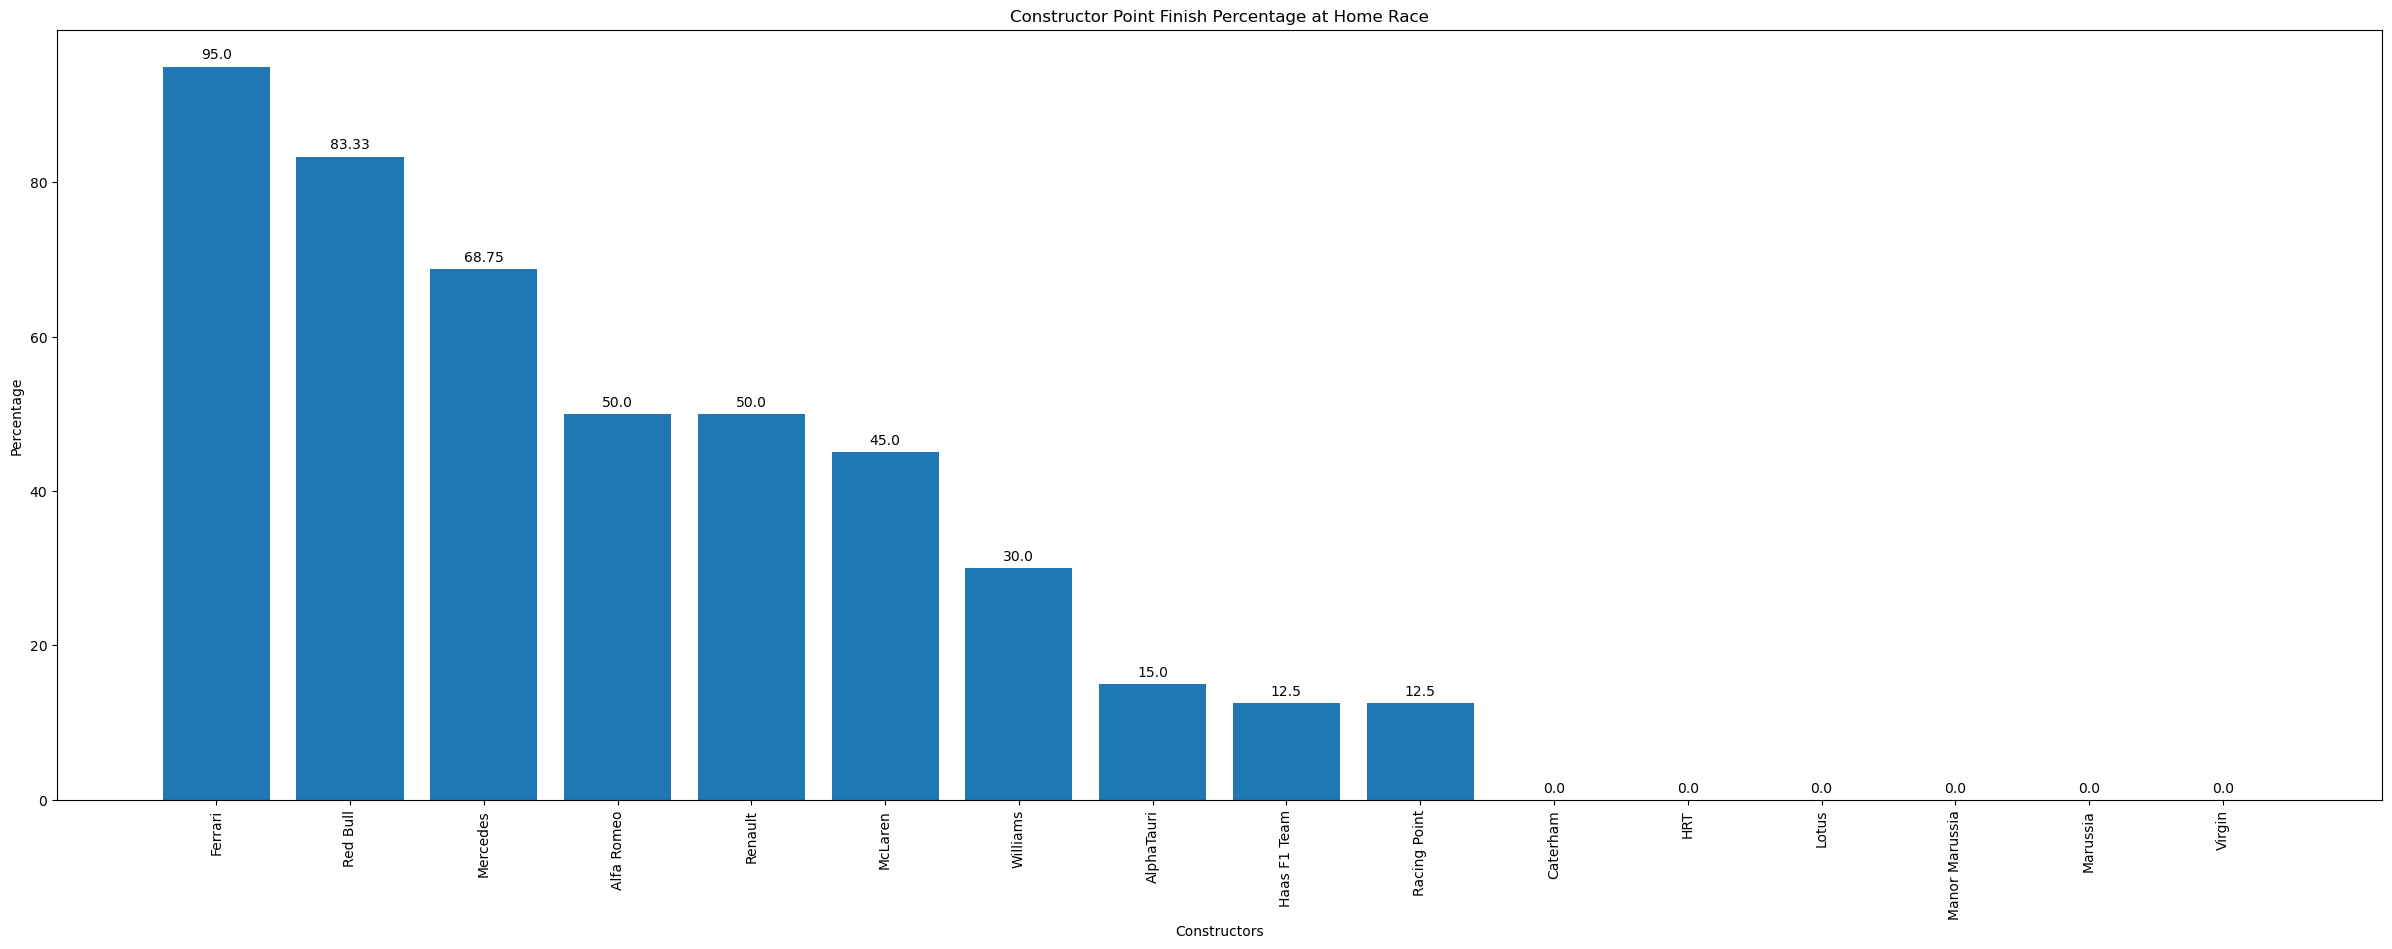

In [20]:


# Calculate points finished at home for constructors (counting finishes where position < 11)
constructor_home_points_finish = data.loc[(data['position'] < 11) & (data['constructor_home'] == 1)].groupby('constructor').count()['position']

# Total home races: Count occurrences of home races instead of summing
total_home_races = data[data['constructor_home'] == 1].groupby('constructor').count()['constructor_home']

# Calculate finish ratio (handle division by zero)
constructor_home_point_finish_ratio = (constructor_home_points_finish * 100 / total_home_races).fillna(0).sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index, height=constructor_home_point_finish_ratio, align='center', width=0.8)

# Customize x-axis and labels
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Percentage')
plt.title('Constructor Point Finish Percentage at Home Race')

# Define font properties for the labels
font = {'size': 10}  # Adjust the size as needed

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 2)}', ha='center', fontdict=font)

# Show the plot
plt.show()


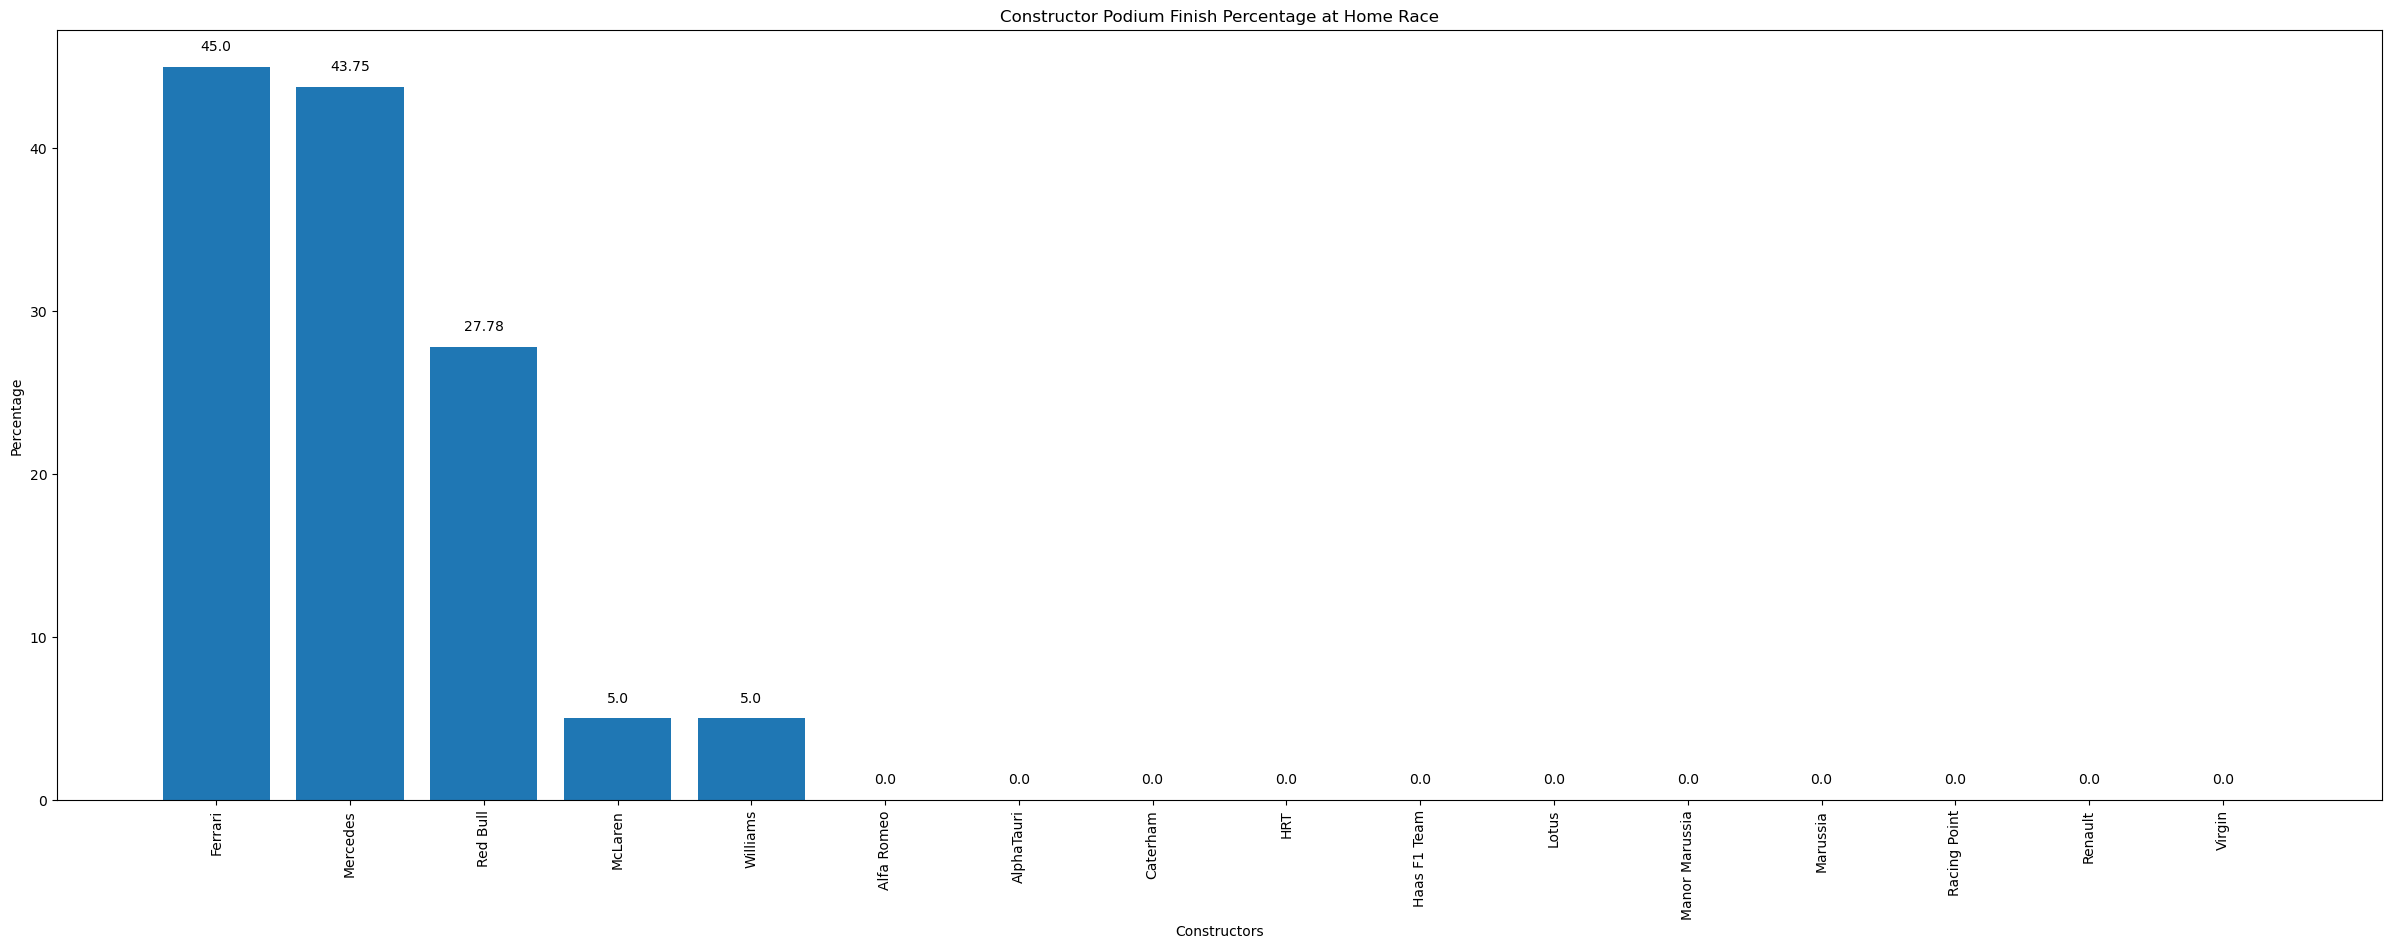

In [21]:

# Calculate podium finishes at home for constructors (counting finishes where position < 4)
constructor_home_points_finish = data.loc[(data['position'] < 4) & (data['constructor_home'] == 1)].groupby('constructor').count()['position']

# Total home races: Count occurrences of home races instead of summing
total_home_races = data[data['constructor_home'] == 1].groupby('constructor').count()['constructor_home']

# Calculate podium finish ratio (handle division by zero)
constructor_home_point_finish_ratio = (constructor_home_points_finish * 100 / total_home_races).fillna(0).sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(30, 10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index, height=constructor_home_point_finish_ratio, align='center', width=0.8)

# Customize x-axis and labels
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Percentage')
plt.title('Constructor Podium Finish Percentage at Home Race')

# Define font properties for the labels
font = {'size': 10}  # Adjust the size as needed

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{round(yval, 2)}', ha='center', fontdict=font)

# Show the plot
plt.show()


In [22]:


# Group by driver and sum the driver_dnf to get the total DNFs per driver
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()

# Group by driver and count the total races entered (this counts the occurrences of driver_dnf)
driver_race_entered = data.groupby('driver')['driver_dnf'].count()

# Calculate the DNF ratio, ensuring to handle division by zero
driver_dnf_ratio = dnf_by_driver / driver_race_entered.replace(0, pd.NA)  # Replace 0 with NA to avoid division by zero

# Calculate driver confidence
driver_confidence = 1 - driver_dnf_ratio.fillna(0)  # Fill NA with 0 for confidence calculation

# Create a dictionary mapping driver names to their confidence scores
driver_confidence_dict = dict(zip(driver_confidence.index, driver_confidence))

# If you want to see the results
print(driver_confidence_dict)


{'Adrian Sutil': 0.868421052631579, 'Alexander Albon': 0.9565217391304348, 'Alexander Rossi': 1.0, 'André Lotterer': 1.0, 'Antonio Giovinazzi': 0.88, 'Brendon Hartley': 0.88, 'Bruno Senna': 0.8260869565217391, 'Carlos Sainz': 0.9038461538461539, 'Charles Leclerc': 0.8444444444444444, 'Charles Pic': 0.9487179487179487, 'Christian Klien': 1.0, 'Daniel Ricciardo': 0.9421965317919075, 'Daniil Kvyat': 0.9175257731958762, 'Esteban Gutiérrez': 0.847457627118644, 'Esteban Ocon': 0.9230769230769231, 'Felipe Massa': 0.9161290322580645, 'Felipe Nasr': 0.925, 'Fernando Alonso': 0.9248554913294798, 'George Russell': 0.9583333333333334, 'Giedo van der Garde': 0.8421052631578947, 'Heikki Kovalainen': 0.95, 'Jaime Alguersuari': 0.9210526315789473, 'Jarno Trulli': 0.972972972972973, 'Jean-Éric Vergne': 0.9137931034482758, 'Jenson Button': 0.9407407407407408, 'Jolyon Palmer': 0.8571428571428572, 'Jules Bianchi': 0.9117647058823529, "Jérôme d'Ambrosio": 0.95, 'Kamui Kobayashi': 0.8356164383561644, 'Karun

In [23]:


# Assuming 'data' is your DataFrame containing the necessary columns.

# Group by constructor and sum the constructor_dnf to get the total DNFs per constructor
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()

# Group by constructor and count the total races entered (this counts the occurrences of constructor_dnf)
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()

# Calculate the DNF ratio, ensuring to handle division by zero
constructor_dnf_ratio = dnf_by_constructor / constructor_race_entered.replace(0, pd.NA)  # Replace 0 with NA to avoid division by zero

# Calculate constructor reliability
constructor_reliability = 1 - constructor_dnf_ratio.fillna(0)  # Fill NA with 0 for reliability calculation

# Create a dictionary mapping constructor names to their reliability scores
constructor_reliability_dict = dict(zip(constructor_reliability.index, constructor_reliability))

# If you want to see the results
print(constructor_reliability_dict)


{'Alfa Romeo': 0.5728643216080402, 'AlphaTauri': 0.5452261306532663, 'Caterham': 0.8214285714285714, 'Ferrari': 0.10199004975124382, 'HRT': 0.8434782608695652, 'Haas F1 Team': 0.6569767441860466, 'Lotus': 0.9210526315789473, 'Manor Marussia': 0.8787878787878788, 'Marussia': 0.8333333333333334, 'McLaren': 0.4085213032581454, 'Mercedes': 0.12219451371571077, 'Racing Point': 0.39152119700748134, 'Red Bull': 0.17500000000000004, 'Renault': 0.46984924623115576, 'Virgin': 0.9078947368421053, 'Williams': 0.5037406483790523}


In [24]:

# Assuming 'data' is your DataFrame containing the necessary columns.
# Ensure that the driver_confidence_dict and constructor_reliability_dict are defined beforehand.

# Assign driver confidence from the dictionary, using .get to handle missing drivers
data['driver_confidence'] = data['driver'].apply(lambda x: driver_confidence_dict.get(x, 0))

# Assign constructor reliability from the dictionary, using .get to handle missing constructors
data['constructor_reliability'] = data['constructor'].apply(lambda x: constructor_reliability_dict.get(x, 0))

# List of active constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']

# List of active drivers
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean', 'Nicholas Latifi']

# Marking active drivers in the DataFrame
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))

# Marking active constructors in the DataFrame
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

# If you want to see the modified DataFrame
print(data.head())


    year       date  quali_pos  statusId  position        dob  \
26  2011 2011-03-27         18        11        18 1977-05-10   
30  2010 2010-03-28          9         1         9 1984-12-07   
34  2017 2017-03-26         11        11        12 1987-08-19   
35  2018 2018-03-25          7         1         8 1987-08-19   
36  2019 2019-03-17         11        11        11 1987-08-19   

   driver_nationality                                        drivers_url  \
26                Ger         http://en.wikipedia.org/wiki/Nick_Heidfeld   
30                Pol         http://en.wikipedia.org/wiki/Robert_Kubica   
34                Ger  http://en.wikipedia.org/wiki/Nico_H%C3%BClkenberg   
35                Ger  http://en.wikipedia.org/wiki/Nico_H%C3%BClkenberg   
36                Ger  http://en.wikipedia.org/wiki/Nico_H%C3%BClkenberg   

   constructor constructor_nationality  ...           driver  \
26     Renault                     Fre  ...    Nick Heidfeld   
30     Renault          

In [25]:
# Correcting the column name
cleaned_data = data[['GP_name', 'quali_pos', 'constructor', 'driver', 'position',
                     'driver_confidence', 'constructor_reliability',  # Fixed spelling here
                     'active_driver', 'active_constructor', 'dob']]

# Filtering the cleaned data for active drivers and constructors
cleaned_data = cleaned_data[(cleaned_data['active_driver'] == 1) & (cleaned_data['active_constructor'] == 1)]

# Saving the cleaned data to a CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)


In [26]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [27]:

from sklearn.preprocessing import StandardScaler, LabelEncoder

x = pd.DataFrame(data)  # Define x as your DataFrame

# Initialize the StandardScaler and LabelEncoder
sc = StandardScaler()
le = LabelEncoder()

# Fit and transform the categorical columns
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])

# Check available columns
print("Available columns in DataFrame:", x.columns)

# Drop unnecessary columns, checking for their existence first
columns_to_drop = ['position', 'active_driver', 'active_constructor']

# Only include 'milliseconds' if it exists in the DataFrame
if 'milliseconds' in x.columns:
    columns_to_drop.append('milliseconds')

X = x.drop(columns=columns_to_drop)  # Use the updated list
y = x['position'].apply(lambda x: position_index(x))  # Ensure position_index function is defined

# If needed, scale the features in X
# X = sc.fit_transform(X)  # Uncomment this line if you want to scale X

# Now you can proceed with your analysis or model training




Available columns in DataFrame: Index(['year', 'date', 'quali_pos', 'statusId', 'position', 'dob',
       'driver_nationality', 'drivers_url', 'constructor',
       'constructor_nationality', 'constructors_url', 'GP_name', 'country',
       'driver', 'age_at_gp_in_days', 'driver_home', 'constructor_home',
       'driver_dnf', 'constructor_dnf', 'driver_confidence',
       'constructor_reliability', 'active_driver', 'active_constructor'],
      dtype='object')


In [28]:


# Assuming 'X' is your feature DataFrame and 'y' is your target variable

# Convert any timestamp columns to numeric (e.g., converting to datetime)
for column in X.select_dtypes(include=[np.datetime64]).columns:
    X[column] = (X[column] - X[column].min()).dt.total_seconds()  # Convert to seconds since the earliest date

# Check and convert any other non-numeric columns to numeric
# Example: If you have categorical columns, use one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Initialize models
models = [
    LogisticRegression(max_iter=1000),  # Increased max_iter to ensure convergence
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier()
]

# Model names for display
names = [
    'Logistic Regression',
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'Support Vector Classifier (SVC)',
    'Gaussian Naive Bayes',
    'K-Neighbors Classifier'
]

# Create a dictionary to map model names to models
model_dict = dict(zip(names, models))

# Initialize lists to store results
mean_results = []
results = []

# Evaluate each model using cross-validation
for name, model in model_dict.items():
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)  # Ensure shuffle is set to True
    result = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    print(f'{name} : {result.mean():.4f}')  # Display mean result rounded to 4 decimal places

# If you want to see the mean results list
print("\nMean Accuracy Results:")
for name, mean in zip(names, mean_results):
    print(f'{name}: {mean:.4f}')



Logistic Regression : 0.5219
Decision Tree Classifier : 0.9493
Random Forest Classifier : 0.9070
Support Vector Classifier (SVC) : 0.5350
Gaussian Naive Bayes : 0.5346
K-Neighbors Classifier : 0.7250

Mean Accuracy Results:
Logistic Regression: 0.5219
Decision Tree Classifier: 0.9493
Random Forest Classifier: 0.9070
Support Vector Classifier (SVC): 0.5350
Gaussian Naive Bayes: 0.5346
K-Neighbors Classifier: 0.7250


Number of results: 6
Number of names: 22


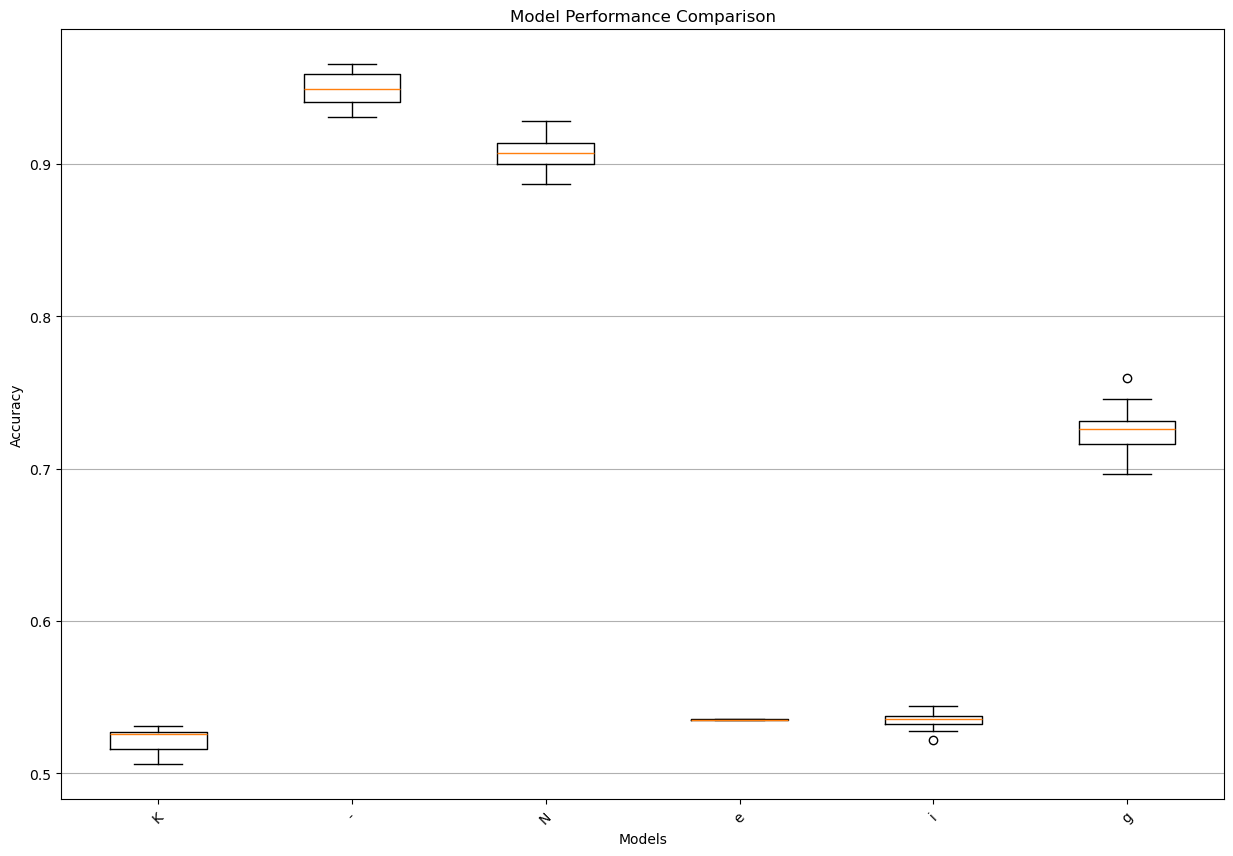

In [29]:
import matplotlib.pyplot as plt

# Check the lengths of results and names
print(f'Number of results: {len(results)}')
print(f'Number of names: {len(name)}')

# Filter results and names to include only those that have valid scores
filtered_results = []
filtered_names = []

for result, model_name in zip(results, name):
    if result is not None and len(result) > 0:  # Check if the result is valid
        filtered_results.append(result)
        filtered_names.append(model_name)

# Ensure that the lengths match after filtering
if len(filtered_results) != len(filtered_names):
    raise ValueError("Length of filtered results and names must match.")

# Create the boxplot
plt.figure(figsize=(15, 10))
plt.boxplot(filtered_results, labels=filtered_names)  # Use filtered results
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for better readability
plt.grid(axis='y')  # Optional: Add horizontal grid lines for better readability
plt.show()


In [30]:
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [31]:
x_d = x_d[x_d['active_driver']==1]

In [32]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create instances of the scalers and encoders
sc = StandardScaler()
le = LabelEncoder()

# Transform categorical columns
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['driver'] = le.fit_transform(x_d['driver'])

# Transform numerical column
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])

# Drop specified columns and ensure to use axis=1 instead of 1
X_d = x_d.drop(['position', 'active_driver'], axis=1)

# Apply the position_index function to create the target variable
y_d = x_d['position'].apply(lambda x: position_index(x))

# Optionally, reset the index of X_d if you want to avoid index issues later
X_d.reset_index(drop=True, inplace=True)


In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Define models and their names
models = [
    LogisticRegression(max_iter=1000),  # Increase max_iter if convergence issues occur
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier()
]

names = [
    'Logistic Regression',
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'Support Vector Classifier',
    'Gaussian Naive Bayes',
    'K-Neighbors Classifier'
]

# Create a dictionary to map models to names
model_dict = dict(zip(models, names))

mean_results_dri = []
results_dri = []

# Perform cross-validation for each model
for model in models:
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)  # Added shuffle for randomness
    result = cross_val_score(model, X_d, y_d, cv=cv, scoring='accuracy')
    
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    
    print(f'{model_dict[model]}: {result.mean():.4f}')  # Formatting the output for better readability


Logistic Regression: 0.9310
Decision Tree Classifier: 0.9078
Random Forest Classifier: 0.9366
Support Vector Classifier: 0.9299
Gaussian Naive Bayes: 0.8681
K-Neighbors Classifier: 0.9140


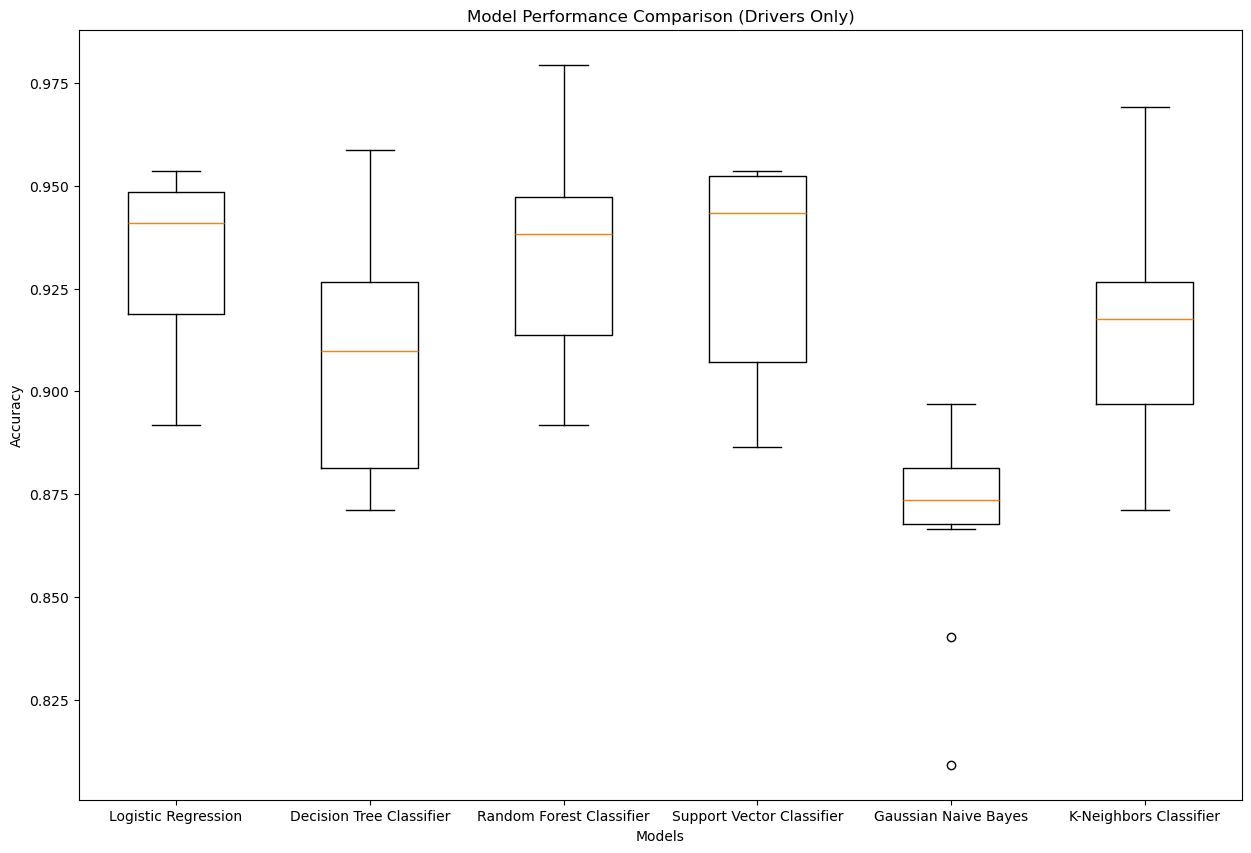

In [34]:
# Ensure results_dri and model names match in length
if len(results_dri) != len(names):
    raise ValueError("Length of results_dri and names must match.")

# Create the boxplot
plt.figure(figsize=(15, 10))
plt.boxplot(results_dri, labels=names)  # Use names instead of name
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison (Drivers Only)')
plt.show()

In [35]:
x_c = ['GP_name', 'quali_pos', 'constructor', 'position', 'constructor_reliability', 'active_constructor']
missing_columns = [col for col in x_c if col not in data.columns]

if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    x_c = data[x_c]



In [36]:
x_c = x_c[x_c['active_constructor']==1]

In [37]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create instances of the scalers and encoders
sc = StandardScaler()
le = LabelEncoder()

# Transform categorical columns
data['GP_name'] = le.fit_transform(data['GP_name'])
data['constructor'] = le.fit_transform(data['constructor'])

# Transform numerical columns
data['quali_pos'] = sc.fit_transform(data[['quali_pos']])
data['constructor_reliability'] = sc.fit_transform(data[['constructor_reliability']])

# Define X_c and y_c, dropping irrelevant columns
X_c = data.drop(['position', 'active_constructor'], axis=1)

# Create the target variable for y_c
y_c = data['position'].apply(lambda x: position_index(x))

# Optionally reset the index of X_c to avoid index issues later
X_c.reset_index(drop=True, inplace=True)



In [38]:
print(X_c.shape)  # Check the shape of your features
print(len(y_c))   # Check the length of your target variable

(4323, 21)
4323


In [39]:
X_c, y_c = X_c.dropna(), y_c.dropna()  # Drop any rows with missing values


In [40]:
X_c.reset_index(drop=True, inplace=True)
y_c.reset_index(drop=True, inplace=True)


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Example data types in X_c
# X_c = <Your DataFrame here>

# Check data types to identify date columns
print(X_c.dtypes)

# Convert date columns ('date', 'dob') to useful numerical features
# Option 1: Convert to Unix timestamp (or)
# X_c['date'] = X_c['date'].astype('int64')  # Unix timestamp
# X_c['dob'] = X_c['dob'].astype('int64')    # Unix timestamp

# Option 2: Extract year, month, and day features
X_c['date_year'] = X_c['date'].dt.year
X_c['date_month'] = X_c['date'].dt.month
X_c['date_day'] = X_c['date'].dt.day

X_c['dob_year'] = X_c['dob'].dt.year
X_c['dob_month'] = X_c['dob'].dt.month
X_c['dob_day'] = X_c['dob'].dt.day

# Drop original 'date' and 'dob' columns if they are no longer needed
X_c = X_c.drop(columns=['date', 'dob'])

# Ensure all other object columns are handled (e.g., convert categorical columns)
# Here you can apply one-hot encoding or label encoding if needed
X_c = pd.get_dummies(X_c, columns=['driver_nationality', 'constructor_nationality', 'country', 'driver', 'age_at_gp_in_days'], drop_first=True)

# Ensure all features are numeric
X_c = X_c.select_dtypes(include=[np.number])

# Prepare the target variable (y_c)
# y_c = <Your target variable here>

# Initialize the models in a dictionary
model_dict = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

mean_results_const = []
results_const = []

# Now run the cross-validation
for name, model in model_dict.items():
    try:
        cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        result = cross_val_score(model, X_c, y_c, cv=cv, scoring='accuracy')
        mean_results_const.append(result.mean())
        results_const.append(result)
        print(f'{name}: {result.mean():.4f}')
    except Exception as e:
        print(f'{name} failed with error: {e}')



year                                int64
date                       datetime64[ns]
quali_pos                         float64
statusId                            int64
dob                        datetime64[ns]
driver_nationality                 object
drivers_url                        object
constructor                         int32
constructor_nationality            object
constructors_url                   object
GP_name                             int32
country                            object
driver                             object
age_at_gp_in_days                  object
driver_home                         int64
constructor_home                    int64
driver_dnf                          int64
constructor_dnf                     int64
driver_confidence                 float64
constructor_reliability           float64
active_driver                       int64
dtype: object


C:\Users\Stuti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Stuti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression: 0.7095
Decision Tree: 0.9357
Random Forest: 0.9577
Support Vector Classifier: 0.5350
Gaussian Naive Bayes: 0.8240
K-Nearest Neighbors: 0.6435


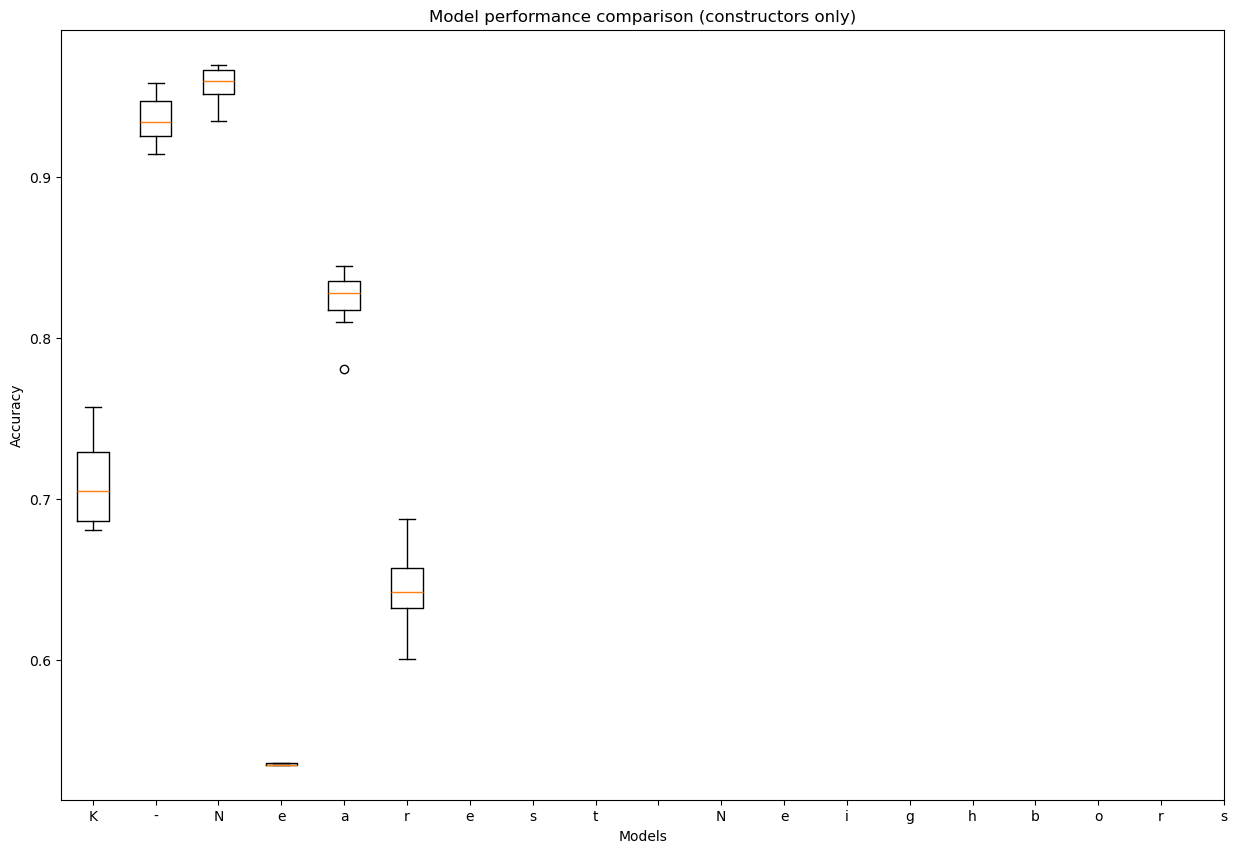

In [42]:
plt.figure(figsize=(15,10))

# Create the boxplot without the 'labels' argument
plt.boxplot(results_const)

# Set the model names as the x-axis labels
plt.xticks(ticks=range(1, len(name) + 1), labels=name)

# Set the labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model performance comparison (constructors only)')

# Show the plot
plt.show()


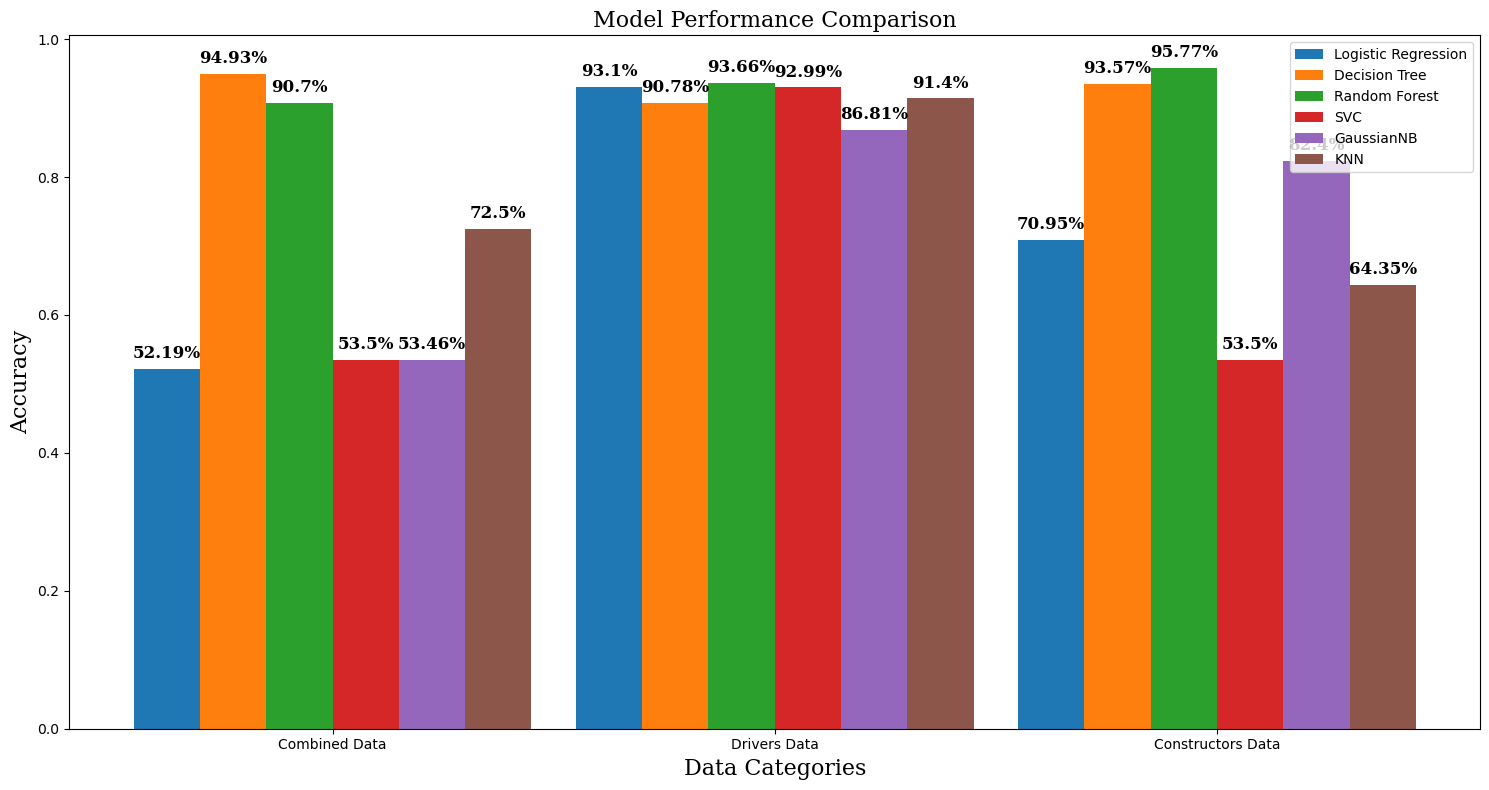

In [43]:


# Results for different models
lr = [mean_results[0], mean_results_dri[0], mean_results_const[0]]
dtc = [mean_results[1], mean_results_dri[1], mean_results_const[1]]
rfc = [mean_results[2], mean_results_dri[2], mean_results_const[2]]
svc = [mean_results[3], mean_results_dri[3], mean_results_const[3]]
gnb = [mean_results[4], mean_results_dri[4], mean_results_const[4]]
knn = [mean_results[5], mean_results_dri[5], mean_results_const[5]]

# Font settings for the text on the plot
font1 = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}
font2 = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 12}

# X-axis positions for the bars
x_ax = np.arange(3)

# Plot size
plt.figure(figsize=(15, 8))

# Create bar plots for each model
bar_width = 0.15  # Bar width to create some spacing between bars

bar1 = plt.bar(x_ax, lr, width=bar_width, label='Logistic Regression')
bar2 = plt.bar(x_ax + bar_width, dtc, width=bar_width, label='Decision Tree')
bar3 = plt.bar(x_ax + 2 * bar_width, rfc, width=bar_width, label='Random Forest')
bar4 = plt.bar(x_ax + 3 * bar_width, svc, width=bar_width, label='SVC')
bar5 = plt.bar(x_ax + 4 * bar_width, gnb, width=bar_width, label='GaussianNB')
bar6 = plt.bar(x_ax + 5 * bar_width, knn, width=bar_width, label='KNN')

# Set x-ticks and x-tick labels
plt.xticks(x_ax + 2.5 * bar_width, ['Combined Data', 'Drivers Data', 'Constructors Data'])

# Adding the labels and titles
plt.xlabel('Data Categories', fontdict=font1)
plt.ylabel('Accuracy', fontdict=font1)
plt.title('Model Performance Comparison', fontdict=font1)

# Add the legend
plt.legend()

# Add the text labels on top of each bar
def add_value_labels(bars, font):
    """Add value labels on the bars."""
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{round(yval * 100, 2)}%', ha='center', va='bottom', fontdict=font)

# Add labels for each set of bars
add_value_labels(bar1, font2)
add_value_labels(bar2, font2)
add_value_labels(bar3, font2)
add_value_labels(bar4, font2)
add_value_labels(bar5, font2)
add_value_labels(bar6, font2)

# Display the plot
plt.tight_layout()
plt.show()


In [44]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [45]:
rf_rand = RandomForestClassifier()

# Set up the RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_rand,
    param_distributions=random_parms,
    n_iter=100,
    cv=10,
    verbose=2,
    n_jobs=-1,
    random_state=42  # For reproducibility
)

# Fit the model
rf_random.fit(X, y)

# Retrieve the best parameters
best_params = rf_random.best_params_

print("Best parameters found: ", best_params)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\Stuti\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'n_estimators': 800, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}


In [46]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=20,min_samples_leaf=1,max_features='sqrt',max_depth=90,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [47]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

In [48]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

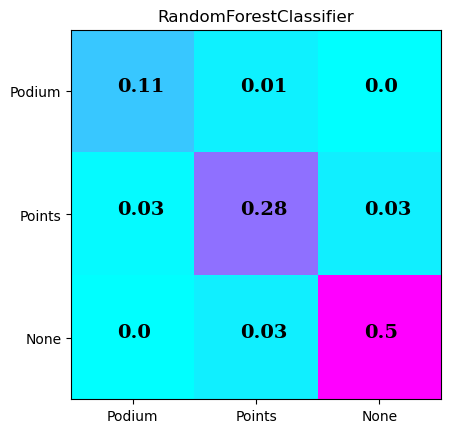

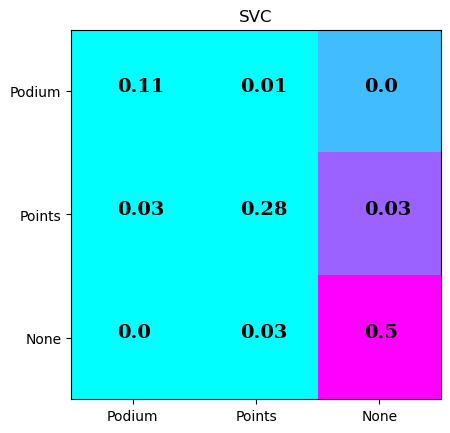

In [49]:
font3 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':14
}
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
ax1.set_xticklabels(['Podium','Points','None'])
ax1.set_yticklabels(['Podium','Points','None'])
ax1.set_title('RandomForestClassifier')
im_rf = ax1.imshow(cnf_mat_rf,cmap='cool')
for i in range(3):
    for j in range(3):
            ax1.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

ax2.set_xticks(np.arange(3))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(['Podium','Points','None'])
ax2.set_yticklabels(['Podium','Points','None'])
ax2.set_title('SVC')
im_svc = ax2.imshow(cnf_mat_svc,cmap='cool')
for i in range(3):
    for j in range(3):
            ax2.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

In [50]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')
svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')
metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall}
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier,SVC
precision_score,0.889793,0.534722
f1_score,0.877747,0.232278
recall_score,0.868214,0.333333
